# Local Variational Inference for a Softmax Model

The local variational method can be extended to multidimensional models by use of the softmax function (see e.g. Ahmed, 2013). In this demo we consider the following model:

\begin{align*}
    x_t &\sim \mathcal{N}(A x_{t-1}, 0.01 I)\\
    y_t &\sim \mathcal{C}at(\sigma(x_t))\,,
\end{align*}

with $\sigma$ a softmax. We start by generating a dataset.

In [11]:
using Random
using ForneyLab
using PyPlot
using LinearAlgebra

# Generate data set
Random.seed!(123)
n_samples = 40
theta = 2*pi/40
A = [cos(theta) -sin(theta) 0.0; sin(theta) cos(theta) 0.0; 0.0 0.0 0.9] # Transition matrix
σ(x) = exp.(x)/sum(exp.(x)) # Softmax function

x_data = []
y_data = []
x_prev = [2.0, 0.0, 2.0]
for t=1:n_samples
    push!(x_data, A*x_prev + sqrt(0.01)*randn(3)) # State transition
    y_data_t = sample(ProbabilityDistribution(Categorical, p=σ(x_data[end])))
    push!(y_data, Vector(y_data_t)); # Observation
    x_prev = x_data[end]
end

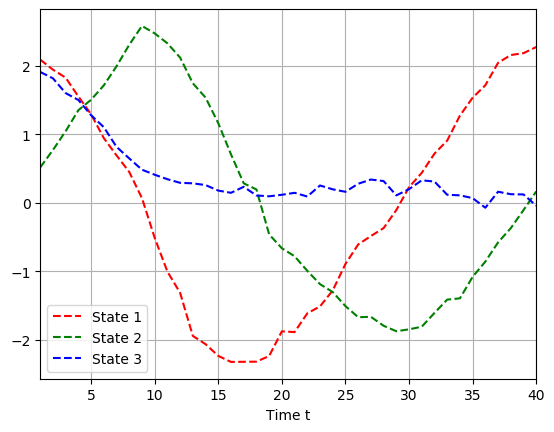

In [12]:
# Plot the generated hidden states
x_data_1 = [x_data_t[1] for x_data_t in x_data]
x_data_2 = [x_data_t[2] for x_data_t in x_data]
x_data_3 = [x_data_t[3] for x_data_t in x_data]

plot(1:n_samples, x_data_1, linestyle="--", color="red", label="State 1")
plot(1:n_samples, x_data_2, linestyle="--", color="green", label="State 2")
plot(1:n_samples, x_data_3, linestyle="--", color="blue", label="State 3")

grid("on")
xlabel("Time t")
xlim(1, n_samples)
legend()
;

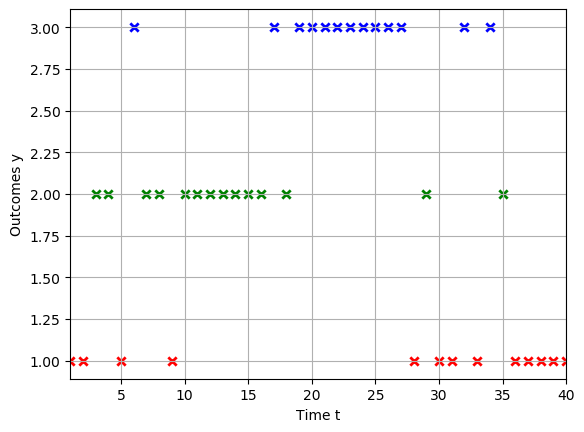

In [13]:
# Plot the generated data
y_data_1 = findall([y_data_t == [1.0,0.0,0.0] for y_data_t in y_data])
y_data_2 = findall([y_data_t == [0.0,1.0,0.0] for y_data_t in y_data])
y_data_3 = findall([y_data_t == [0.0,0.0,1.0] for y_data_t in y_data])

scatter(y_data_1, ones(length(y_data_1)), color="red", marker="x", lw=2)
scatter(y_data_2, 2*ones(length(y_data_2)), color="green", marker="x", lw=2)
scatter(y_data_3, 3*ones(length(y_data_3)), color="blue", marker="x", lw=2)

grid("on")
xlabel("Time t")
ylabel("Outcomes y")
xlim(1, n_samples)
;

# Model specification

The model specification includes local variational parameters `xi` and `a`, which are used to define an upperbound on the softmax (Bouchard, 2007).

In [14]:
g = FactorGraph()

# State prior
@RV x_0 ~ GaussianMeanVariance(ones(3), 100.0*diageye(3))

x = Vector{Variable}(undef, n_samples)
xi = Vector{Variable}(undef, n_samples)
a = Vector{Variable}(undef, n_samples)
y = Vector{Variable}(undef, n_samples)

x_t_min = x_0
for t = 1:n_samples
    @RV x[t] ~ GaussianMeanPrecision(A*x_t_min, 100.0*diageye(3))
    @RV xi[t]
    @RV a[t]
    @RV y[t] ~ Softmax(x[t], xi[t], a[t])

    # Data placeholder
    placeholder(y[t], :y, index=t, dims=(3,))
    
    # Reset state for next step
    x_t_min = x[t]
end
;

# Algorithm generation

Since we are interested in optimizing the local variational parameters `xi`, `a` together with the hidden state sequence `x`, we construct an algorithm that also updates `xi` and `a`. However, because we upper-bound the softmax, the free energy is no longer guaranteed to be a upper bound on surprise. This is in contrast to local variational estimation for the logistic function, which is lower bounded (see the corresponding demo).

In [15]:
pfz = PosteriorFactorization([x_0; x], xi, a, ids=[:X, :Xi, :A])
algo = messagePassingAlgorithm([xi; a])
source_code = algorithmSourceCode(algo);

In [16]:
# println(source_code) # Uncomment to inspect algorithm code

# Execution

For execution we initialize the local variational parameters and iterate the automatically derived algorithm.

In [17]:
eval(Meta.parse(source_code));

In [18]:
# Pre-initialize marginals
marginals = Dict()
for t=1:n_samples
    marginals[:xi_*t] = ProbabilityDistribution(Multivariate, Function, mode=ones(3))
    marginals[:a_*t] = ProbabilityDistribution(Function, mode=1.0)
end

data = Dict(:y  => y_data)

n_its = 20
for i = 1:n_its
    stepX!(data, marginals) # Update hidden state
    stepXi!(data, marginals) # Update local variational parameters
    stepA!(data, marginals)
end

# Results

Results show that the algorithm accurately estimates the hidden state.

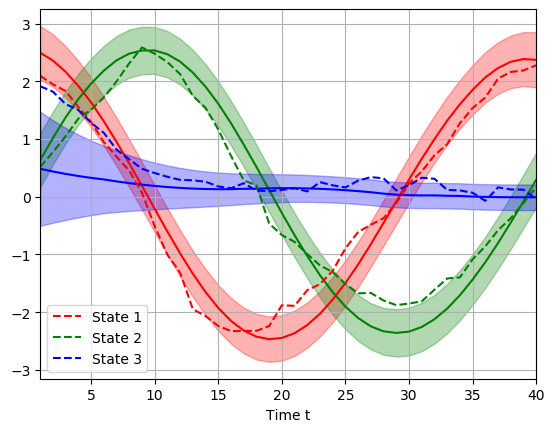

In [19]:
# Extract posterior state statistics
m_x_1 = [mean(marginals[:x_*t])[1] for t = 1:n_samples]
v_x_1 = [cov(marginals[:x_*t])[1,1] for t = 1:n_samples]
m_x_2 = [mean(marginals[:x_*t])[2] for t = 1:n_samples]
v_x_2 = [cov(marginals[:x_*t])[2,2] for t = 1:n_samples]
m_x_3 = [mean(marginals[:x_*t])[3] for t = 1:n_samples]
v_x_3 = [cov(marginals[:x_*t])[3,3] for t = 1:n_samples]

plot(1:n_samples, m_x_1, color="red")
fill_between(1:n_samples, m_x_1-sqrt.(v_x_1), m_x_1+sqrt.(v_x_1), color="red", alpha=0.3);
plot(1:n_samples, m_x_2, color="green")
fill_between(1:n_samples, m_x_2-sqrt.(v_x_2), m_x_2+sqrt.(v_x_2), color="green", alpha=0.3);
plot(1:n_samples, m_x_3, color="blue")
fill_between(1:n_samples, m_x_3-sqrt.(v_x_3), m_x_3+sqrt.(v_x_3), color="blue", alpha=0.3);

# Plot true states
plot(1:n_samples, x_data_1, linestyle="--", color="red", label="State 1")
plot(1:n_samples, x_data_2, linestyle="--", color="green", label="State 2")
plot(1:n_samples, x_data_3, linestyle="--", color="blue", label="State 3")

xlim(1, n_samples)
grid("on")
xlabel("Time t")
legend(loc=3)
;

Because the softmax function is approximated by an upper bound (Bouchard, 2007), the free energy is no longer a bound on surprise, and no longer guaranteed to monotonically decrease over iterations.

### References

Bouchard, 2007 "Efficient Bounds for the Softmax Function"

Ahmed, 2013, "Bayesian Multicategorical Soft Data Fusion for Human-Robot Collaboration"